In [74]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

%matplotlib inline

In [75]:
mu1, sig1 = [-5., -5.], 1.
mu2, sig2 = [5., 5.], 1.
mu3, sig3 = [-5., 5.], 1.

NOISE_DIM = 2   # what is the dimension of noise

In [76]:
def get_uniform(batch_size):
  return torch.rand(batch_size, NOISE_DIM)      # shape of tensor -> (batch_size, NOISE_DIM)

def plot_2d_density(xy):
  cmap = sns.cubehelix_palette(light=1, as_cmap=True)
  sns.kdeplot(x = xy[:,0], y = xy[:, 1], cut=5, label='pdata')

def sample_real_data(batch_size):
  n1, n2 = int(batch_size/3), int(batch_size/3)
  n3 = batch_size - n1 - n2

  data = np.vstack([np.random.normal(mu1, sig1, size=(n1, 2)),
                   np.random.normal(mu2, sig2, size=(n2, 2)),
                   np.random.normal(mu3, sig3, size=(n3, 2))
                   ])                                          # shape of tensor -> (batch_size = n1 + n2 + n3, 2)

  return torch.FloatTensor(data)

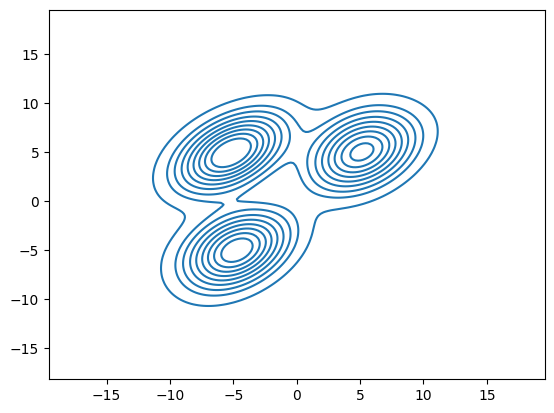

In [77]:
plot_2d_density(sample_real_data(64).data.numpy())

In [78]:
class Generator(nn.Module):
  def __init__(self):

    """
    Generator transform the uniform distribution to a normal distribution
    """

    super().__init__()
    self.main = nn.Sequential(
        nn.Linear(in_features=NOISE_DIM, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=2)
    )

  def forward(self, x):
    return self.main(x)

class Discriminator(nn.Module):
  def __init__(self):

    """
    Disc(x) return probability of x to be real class
    """

    super().__init__()
    self.main = nn.Sequential(
        nn.Linear(in_features=2, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.main(x)


gen = Generator()
disc = Discriminator()

In [79]:
generator_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)
discriminator_opt = torch.optim.SGD(disc.parameters(), lr=1e-3)

In [80]:
def update_D(batch_size):
  # 1. sample real data
  # 2. compute probability of real object to be real

  real_sample = sample_real_data(batch_size)
  prob_real_is_real = disc(real_sample)

  # 1. sample noise
  # 2. obtain generated samples
  # 3. compute probability of fake object to be fake

  noise = get_uniform(batch_size)
  generated_samples = gen(noise)
  prob_fake_is_fake = 1 - disc(generated_samples)


  # compute loss function

  loss = (- torch.log(prob_real_is_real) - torch.log(prob_fake_is_fake)).mean()

  # make gradient step
  discriminator_opt.zero_grad()
  loss.backward()
  discriminator_opt.step()

  return loss.data.numpy().item()

In [81]:
def update_G(batch_size):

  # 1. sample noise
  # 2. obtain generated samples
  # 3. compute probability of fake object to be real

  noise = get_uniform(batch_size)
  generated_samples = gen(noise)
  prob_fake_is_real = disc(generated_samples)


  # compute loss function

  loss = (- torch.log(prob_fake_is_real)).mean()

  # make gradient step
  generator_opt.zero_grad()
  loss.backward()
  generator_opt.step()

  return loss.data.numpy().item()

In [83]:
N_DISC_OPERATIONS = 5      # number of updates for discriminator on each iteration (should be tuned)
BATCH_SIZE = 64

for i in range(10000):

  for _ in range(N_DISC_OPERATIONS):
    update_D(BATCH_SIZE)

  update_G(BATCH_SIZE)

  if i % 300 == 0:
    clear_output(True)
    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1)
    plt.title('Real data')
    plot_2d_density(sample_real_data(1000).data.numpy())
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Generated data')
    plot_2d_density(gen(get_uniform(100)).data.numpy())

    axes = plt.gca()
    axes.set_ylim([-15,15])
    axes.set_xlim([-15,15])

    plt.show()



KeyboardInterrupt: ignored

## Above result have **mode collapse problem**